In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import PIL
import os
import argparse
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms.functional as TF
from torchvision import transforms
import random
import cv2

In [3]:
# parser = argparse.ArgumentParser(description="PyTorch loader")
# parser.add_argument('--batch-size', type=int, default=8)
# parser.add_argument('--data_path', type=str, default='Volumes//FILIPE//Bases//mamografia//preprocessed')
# args = parser.parse_args()

In [4]:
args={
    'data_path': "/Volumes/FILIPE/Bases/mamografia/preprocessed",
    "batch_size": 16
}

In [5]:
# dataset_path = "/Volumes/FILIPE/Bases/mamografia/preprocessed"
dataset_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed"
# train_path = os.path.join(dataset_path,"train")
df_train = pd.read_csv(os.path.join(dataset_path,"annotations_train.csv"))

In [6]:
df_train.head()

,identifier,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,image_full_png_path,image_mask_png_path,binary pathology
0,P_00001_LEFT_CC,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_FULL.png,Mass-Training_P_00001_LEFT_CC_MASK_1.png,1
1,P_00001_LEFT_MLO,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_FULL.png,Mass-Training_P_00001_LEFT_MLO_MASK_1.png,1
2,P_00004_LEFT_CC,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_FULL.png,Mass-Training_P_00004_LEFT_CC_MASK_1.png,0
3,P_00004_LEFT_MLO,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_FULL.png,Mass-Training_P_00004_LEFT_MLO_MASK_1.png,0
4,P_00004_RIGHT_MLO,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_FULL.png,Mass-Training_P_00004_RIGHT_MLO_MASK_1.png,0


In [7]:
df_train["image_full_png_path"].values

array(['Mass-Training_P_00001_LEFT_CC_FULL.png',
       'Mass-Training_P_00001_LEFT_MLO_FULL.png',
       'Mass-Training_P_00004_LEFT_CC_FULL.png', ...,
       'Mass-Training_P_02079_RIGHT_MLO_FULL.png',
       'Mass-Training_P_02092_LEFT_CC_FULL.png',
       'Mass-Training_P_02092_LEFT_MLO_FULL.png'], dtype=object)

In [8]:
df_train["binary pathology"].values

array([1, 1, 0, ..., 1, 1, 1])

In [9]:
# temp_path = os.path.join(train_path, 'full', os.listdir(os.path.join(train_path,'full'))[0])

In [84]:
class CBIS_DDSM(Dataset):
    # including hard labels & soft labels
    def __init__(self, data_path, train=True):
        # self.data, self.masks, self.targets =  data, masks, labels
        
        # self.transform = transform
        self.train = train
        
        self.img_path = []
        self.mask_path = []
        self.labels = []
        
        if self.train:
            # split_path = os.path.join(data_path,"train")
            df = pd.read_csv(os.path.join(dataset_path,"annotations_train.csv"))
            img_paths = df["image_full_png_path"].values
            mask_paths = df["image_mask_png_path"].values
            targets = df["binary pathology"].values
            
            self.img_path = [os.path.join(dataset_path,"train","full",x) for x in img_paths]
            self.mask_path = [os.path.join(dataset_path,"train","merged_masks",x) for x in mask_paths]
            self.labels = targets
            

        else:  
            #test set    
            df = pd.read_csv(os.path.join(dataset_path,"annotations_test.csv"))
            img_paths = df["image_full_png_path"].values
            mask_paths = df["image_mask_png_path"].values
            targets = df["binary pathology"].values
            
            self.img_path = [os.path.join(dataset_path,"test","full",x) for x in img_paths]
            self.mask_path = [os.path.join(dataset_path,"test","merged_masks",x) for x in mask_paths]
            self.labels = targets
            

    def transform_train(self, image, mask, size1=320, size=299):
        # Resize
        resize = transforms.Resize(size=(size1, size1))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(size, size))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        
        # Normalize
        image = TF.normalize(image, mean=mean, std=std)
        mask = TF.normalize(mask, mean=mean, std=std)
        
        return image, mask
    
    def transform_test(self, image, mask, size1=320, size=299):
        # Resize
        resize = transforms.Resize(size=(size1, size1))
        image = resize(image)
        mask = resize(mask)

#         Random crop
#         i, j, h, w = transforms.CenterCrop.get_params(
#             image, output_size=(size, size))
#         image = TF.center_crop(image,size)
#         mask = TF.center_crop(mask, size)

#         # Random horizontal flipping
#         if random.random() > 0.5:
#             image = TF.hflip(image)
#             mask = TF.hflip(mask)

#         # # Random vertical flipping
#         if random.random() > 0.5:
#             image = TF.vflip(image)
#             mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        
        #  Normalize
        image = TF.normalize(image, mean=mean, std=std)
        mask = TF.normalize(mask, mean=mean, std=std)
        
        return image, mask
    
    
            
            
    def __getitem__(self, index):
        img, mask, target = self.img_path[index], self.mask_path[index], self.labels[index]
            
        
        img = cv2.imread(img)   #The image was saved using cv2. For some reason it only works if read using cv2 and then moving to PIL
        img  = Image.fromarray(img) # transform into PIL image
        mask = cv2.imread(mask)
        mask = Image.fromarray(mask)  #bineary
        # img = Image.open(img).convert('RGB')
        # mask = Image.open(mask).convert('RGB')

        # if self.transform is not None:
        #     img = self.transform(img)
        #     mask = self.transform(mask)    #need to garantee that the transform is the same for image and mask
        
        if self.train:
            img, mask = self.transform_train(img, mask)
        else:
            img, mask = self.transform_test(img, mask)
            
            
            

        sample = {'image':img, 'mask': mask, 'target':target, 'index':index, 'path':self.img_path[index]}
        return sample


    def __len__(self):
        return len(self.img_path)
    


In [85]:
def get_loaders(args, **kwargs):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    size = 100
    
#     transform_train = torchvision.transforms.Compose([
#         torchvision.transforms.Resize(size, interpolation=PIL.Image.BICUBIC),
#         torchvision.transforms.RandomCrop(size, padding=4),
#         torchvision.transforms.RandomHorizontalFlip(),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean, std),
#     ])
        
#     transform_test = torchvision.transforms.Compose([
#         torchvision.transforms.Resize(size, interpolation=PIL.Image.BICUBIC),
#         torchvision.transforms.CenterCrop(size),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean, std)
#     ])
    
    trainset = CBIS_DDSM(data_path = args['data_path'], train=True)
    testset = CBIS_DDSM(data_path = args['data_path'], train=False)
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True, **kwargs) #Normal training
    test_loader = torch.utils.data.DataLoader(testset, batch_size=args['batch_size'], shuffle=False, **kwargs) #Normal test
    
    return train_loader, test_loader
    

In [86]:
train_loader, test_loader = get_loaders(args)

In [87]:
train_iter = iter(train_loader)

In [88]:
test_iter = iter(test_loader)

In [89]:
# batch = train_iter.next()
batch = test_iter.next()

In [67]:
batch['image'][0].min()

tensor(-1.)

In [90]:
def unnormalize(img, std=[0.5,0.5,0.5], mean=[0.5,0.5,0.5]):
    # Unormalize image
    MEAN = torch.tensor(mean)
    STD = torch.tensor(std)

    x = img * STD[:, None, None] + MEAN[:, None, None]
    return x

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/Mass-Test_P_00016_LEFT_CC_FULL.png


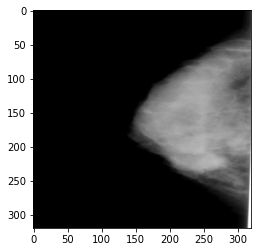

In [91]:
#plt.imshow(  batch['image'][0].permute(1, 2, 0)  )
plt.imshow(  unnormalize(batch['image'][0]).permute(1, 2, 0)  )
# plt.imshow(  batch['image'][0] )
print(batch['path'][0])

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/full/Mass-Training_P_00079_RIGHT_CC_FULL.png


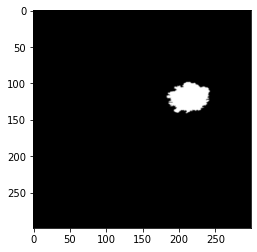

In [75]:
#plt.imshow(  batch['image'][0].permute(1, 2, 0)  )
plt.imshow(  unnormalize(batch['mask'][0].mean(0,keepdim=True)).permute(1, 2, 0)  )
# plt.imshow(  batch['image'][0] )
print(batch['path'][0])

In [72]:
batch['mask'][0].shape

torch.Size([3, 299, 299])

In [34]:
z = x.mean(1, keepdim=True)
>>> z.shape

torch.Size([16, 299, 299])

In [73]:
batch['mask'].shape

torch.Size([16, 3, 299, 299])

In [74]:
batch['mask'].mean(1,keepdim=True).shape

torch.Size([16, 1, 299, 299])

In [71]:
batch['mask'][0].mean(0,keepdim=True).shape

torch.Size([1, 299, 299])

In [166]:
# temp_path = "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/full/Mass-Training_P_01853_LEFT_MLO_FULL.png"
temp_path = batch['path'][0]
print(temp_path)

/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/full/Mass-Training_P_00982_RIGHT_CC_FULL.png


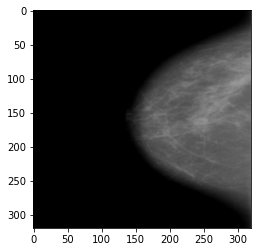

In [197]:
img = cv2.imread(temp_path)   #The image was saved using cv2. For some reason it only works if read using cv2 and then moving to PIL
img  = Image.fromarray(img)

resize = transforms.Resize(size=(320, 320))
img = resize(img)

# Transform to tensor
img = TF.to_tensor(img)


mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

#  Normalize
image = TF.normalize(img, mean=mean, std=std)





# Unormalize image
MEAN = torch.tensor([0.5, 0.5, 0.5])
STD = torch.tensor([0.5, 0.5, 0.5])

x = image * STD[:, None, None] + MEAN[:, None, None]
plt.imshow(x.numpy().transpose(1, 2, 0))

0
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/full/Mass-Training_P_01674_LEFT_CC_FULL.png
1
/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/train/full/Mass-Training_P_00519_RIGHT_MLO_FULL.png


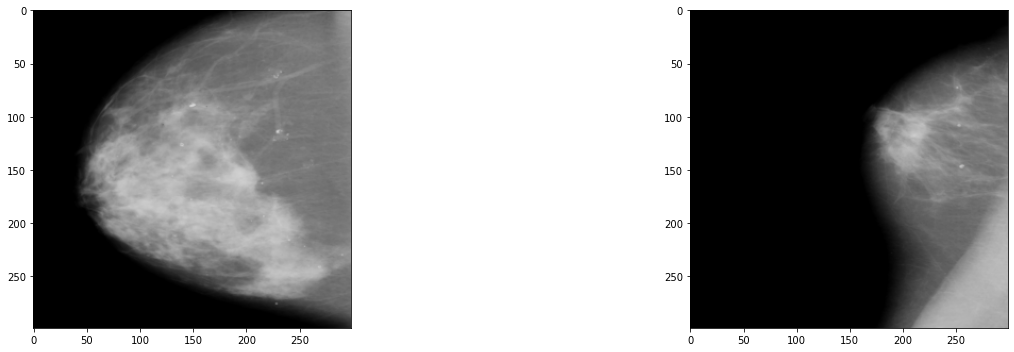

In [205]:
# Plot together
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (22, 5))

for i in range(2):
    print(i)
    ax[i].imshow(unnormalize(batch['image'][i]).permute(1,2,0), cmap="gray")
    print(batch['path'][i])
    # ax[i].set_title(f"{ds[i].PatientID}")
    
plt.tight_layout()

### Debugging save png and read

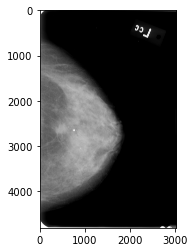

In [80]:
import pydicom

img_dcm_path = "/datasets/mamografia/CBIS-DDSM_organized/images/original/train/Mass-Training_P_00001_LEFT_CC_FULL.dcm"
img_dcm= pydicom.dcmread(img_dcm_path)
fullmamm = img_dcm.pixel_array

plt.imshow(fullmamm, cmap="gray")

In [85]:
pil_image = Image.fromarray(fullmamm)
pil_image.show()

In [81]:
import cv2
cv2.imwrite('my_image.png', fullmamm)

True

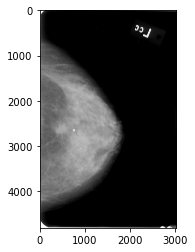

In [83]:
png_image = cv2.imread('my_image.png')
plt.imshow(png_image, cmap='gray')

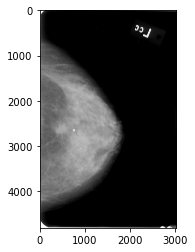

In [88]:
png_image = cv2.imread('my_image.png')
# image = Image.open('my_image.png')
image = Image.fromarray(png_image)
# image.show()
plt.imshow(image, cmap='gray')

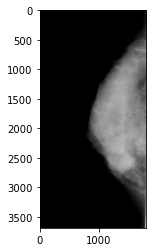

In [84]:
png_image = cv2.imread("/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed/test/full/Mass-Test_P_00016_LEFT_CC_FULL.png")
plt.imshow(png_image, cmap='gray')